In [1]:
import generator as g
import time

import string_similarity_classed as s
from shingling import Shingler
from lsh_no_banding_classed import MinHashLSHProcessor
from calculate_accuracy import CalculateAccuracy

from clusterring import Clustering

import spark_config

# TODO: Turn the output into a json for easier evaluation
# TODO: Create a scheme for automatic runs:
    # Create data once, traverse the parameter values.
    # Repeat many times.
    # parameters to be set: jaro_th, jaccard_th, length of the signature matrix.

test = True

# Data generation
st = time.time()
generator = g.Generator()
generator._set_()
generator.generate_process_patterns()
generator.populate_processes()
print("--- %s seconds ---" % (time.time() - st))


--- 0.043883562088012695 seconds ---


In [2]:
spark = spark_config._create_spark_session()
st_solution = time.time()

# string similarity is used
string_sim = s.StringSimilarity(spark=spark, jaro_or_edit="jaro", edit_th=5, jaro_th=0.8)
string_sim.run()
# string_sim.collapsed_data.show(truncate=False)

ss = Clustering(spark_session=spark)

features = ss._calculate_initial_features_(string_sim.collapsed_data)
print(features)
shing = Shingler(spark_session = string_sim.spark, df = string_sim.collapsed_data)
shing.run()

minhasher = MinHashLSHProcessor(spark_session=string_sim.spark, sparse_vector_df=shing.sparse_vectors_df, jaccard_th=0.2, signature_size=20)
minhasher.run()
minhasher.final_similarity_groups.toPandas().to_csv('final_similarity_groups.csv')

solution_time = time.time() - st_solution
print(solution_time)

minhasher.final_similarity_groups.show(n=10)

# minhasher.final_similarity_groups

+-----------------------+-----------------------+-------------+---------+---+
|Caller                 |Target                 |Time         |EventType|PID|
+-----------------------+-----------------------+-------------+---------+---+
|None                   |5SZIB3C                |1719642448008|Request  |0  |
|5SZIB3C                |92UJAA                 |1719642448169|Request  |0  |
|92UJAA                 |5SZIB3C                |1719642448412|Response |0  |
|5SZIB3C                |JJMHK8MFRVBPO9YL       |1719642448584|Request  |0  |
|None                   |JJMHK8MFRVBPO9YL       |1719642449008|Request  |1  |
|JJMHK8MFRVBPO9YL       |E746NE1                |1719642449238|Request  |0  |
|JJMHK8MFRVBPO9YL       |None                   |1719642449405|Response |1  |
|E746NE1                |JJMHK8MFRVBPO9YL       |1719642449703|Response |0  |
|None                   |49QZ93                 |1719642450008|Request  |2  |
|JJMHK8MFRVBPO9YL       |5SZIB3C                |1719642450232|R

c:\Users\ratus\anaconda3\envs\ma-systems\lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
c:\Users\ratus\anaconda3\envs\ma-systems\lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+-------------+
|id |component    |
+---+-------------+
|7  |25769803776  |
|15 |60129542144  |
|11 |94489280512  |
|29 |120259084288 |
|42 |128849018880 |
|73 |137438953472 |
|87 |137438953473 |
|64 |128849018880 |
|3  |154618822656 |
|34 |171798691840 |
|59 |197568495616 |
|8  |137438953473 |
|22 |128849018880 |
|28 |249108103169 |
|16 |128849018880 |
|35 |25769803776  |
|52 |283467841538 |
|0  |137438953472 |
|71 |154618822656 |
|47 |25769803776  |
|96 |171798691840 |
|43 |412316860416 |
|5  |420906795008 |
|31 |60129542144  |
|18 |455266533376 |
|70 |463856467968 |
|27 |137438953473 |
|61 |412316860416 |
|17 |412316860416 |
|26 |137438953472 |
|46 |455266533376 |
|78 |420906795008 |
|77 |627065225216 |
|6  |644245094400 |
|90 |704374636544 |
|19 |25769803776  |
|23 |747324309504 |
|55 |644245094400 |
|93 |25769803776  |
|95 |137438953472 |
|38 |283467841538 |
|40 |137438953472 |
|25 |128849018880 |
|44 |171798691840 |
|53 |420906795008 |
|92 |970662608896 |
|86 |627065225216 |


In [3]:
acc_calculator = CalculateAccuracy(spark_session=string_sim.spark)
acc_calculator.calculate_accuracy(match_df = minhasher.final_similarity_groups)

#solution_time = time.time() - st_solution
final_acc = acc_calculator.accuracy

Starting accuracy calculation...


Row(component='747324309504', pattern_id=12, count=3)
Row(component='68', pattern_id=1, count=1)
Row(component='420906795008', pattern_id=13, count=7)
Row(component='154618822656', pattern_id=16, count=3)
Row(component='171798691840', pattern_id=6, count=3)
Row(component='54', pattern_id=3, count=1)
Row(component='25769803776', pattern_id=5, count=6)
Row(component='137438953473', pattern_id=19, count=3)
Row(component='412316860416', pattern_id=15, count=3)
Row(component='1047972020224', pattern_id=17, count=3)
Row(component='463856467968', pattern_id=9, count=4)
Row(component='128849018880', pattern_id=4, count=7)
Row(component='60129542144', pattern_id=8, count=5)
Row(component='704374636544', pattern_id=7, count=6)
Row(component='30', pattern_id=10, count=1)
Row(component='137438953472', pattern_id=11, count=6)
Row(component='970662608896', pattern_id=14, count=2)
Row(component='455266533376', pattern_id=2, count=2)
Row(component='94489280512', pattern_id=0, count=2)
Row(component='2

In [22]:
import clusterring

a = clusterring.Clustering(spark_session=spark)


In [8]:
import clusterring

c = clusterring.Clustering(spark_session=spark)
df = c._prepare_all_features_(minhasher.final_similarity_groups, features)


+-------------+--------------+------------------+------------+------------+
|    component|average_length|  average_duration|max_duration|min_duration|
+-------------+--------------+------------------+------------+------------+
| 154618822656|           5.0|            8314.0|       11721|        6478|
|           51|           5.0|            7919.0|        7919|        7919|
|           54|           5.0|           18694.0|       18694|       18694|
|           69|           5.0|            5183.0|        5183|        5183|
| 249108103169|           4.0|            5230.5|        5233|        5228|
|           30|           5.0|            4338.0|        4338|        4338|
|           85|           5.0|           13949.0|       13949|       13949|
|           98|           5.0|            4114.0|        4114|        4114|
|           99|           5.0|            8579.0|        8579|        8579|
|1047972020224|           5.0| 8586.333333333334|       12239|        5264|
| 4209067950

In [23]:
clusters = a.make_predictions(df)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\ratus\anaconda3\envs\ma-systems\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\ratus\anaconda3\envs\ma-systems\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "c:\Users\ratus\anaconda3\envs\ma-systems\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [9]:
c.make_predictions(df)

Silhouette with squared euclidean distance = 0.6013773883746137
Cluster Centers: 
[4.77777778e+00 5.09238889e+03 5.13600000e+03 5.04877778e+03]
[1.71428571e+00 1.85850000e+03 2.38528571e+03 1.31871429e+03]
[5.0000e+00 2.5681e+04 2.5681e+04 2.5681e+04]
[1.60000000e+00 3.08006476e+03 8.64040000e+03 9.53800000e+02]
[5.00000e+00 1.59005e+04 1.59600e+04 1.58410e+04]
[5.00000000e+00 1.13784796e+04 1.23407143e+04 1.03512857e+04]
[4.90000000e+00 8.11948333e+03 9.99990000e+03 6.42460000e+03]
+----------+----------------------------------------------------------------------------------------------------+
|prediction|processes                                                                                           |
+----------+----------------------------------------------------------------------------------------------------+
|1         |[89, 412316860416, 171798691840, 704374636544, 21, 283467841538, 137438953473]                      |
|6         |[154618822656, 51, 99, 1047972020224, 463856

In [15]:
clusters.show()

AttributeError: 'NoneType' object has no attribute 'show'

In [12]:
clusters.toPandas().to_csv("clusters.csv", header=True)

AttributeError: 'NoneType' object has no attribute 'toPandas'

In [ ]:
# def average_length(col):
#     a = features.filter(df.PID in col)

#     return a
# df = minhasher.final_similarity_groups
# length_udf = udf(lambda x, y: average_length(x, y), IntegerType())

# a = df.join(features, features.PID == df.id)

# a.show()


+---+------------+---+--------+------+
| id|   component|PID|Duration|Length|
+---+------------+---+--------+------+
| 51| 25769803776| 51|    1544|     1|
| 15| 60129542144| 15|     353|     1|
| 54| 60129542145| 54|    3121|     2|
| 11| 94489280512| 11|    3265|     3|
| 29| 25769803776| 29|     327|     1|
| 69|120259084289| 69|     708|     1|
| 42|128849018880| 42|   10752|     5|
| 87|137438953472| 87|    1339|     1|
| 64|146028888064| 64|   15052|     5|
|  3| 60129542145|  3|    2773|     2|
| 30|163208757248| 30|    5465|     5|
| 59|197568495616| 59|    2394|     3|
| 22| 25769803776| 22|     332|     1|
| 28|120259084289| 28|    5336|     1|
| 16|283467841536| 16|     571|     1|
| 35| 60129542145| 35|    2179|     2|
| 52|283467841538| 52|    4180|     3|
|  0|300647710720|  0|    1293|     1|
| 71|309237645312| 71|     497|     1|
| 98|120259084289| 98|     129|     1|
+---+------------+---+--------+------+
only showing top 20 rows



In [ ]:
# grouped_df = a.groupBy('component') \
#     .agg(F.avg('Length').alias('average_length'),
#         F.avg('Duration').alias('average_duration'),
#         F.max("Duration").alias('max_duration'),
#         F.min("Duration").alias('min_duration'))
#     # .withColumn('Duration', length_udf(col('ID')))
# grouped_df.show(n=500)

# grouped_df.toPandas().to_csv('clustering.csv')


+-------------+--------------+------------------+------------+------------+
|    component|average_length|  average_duration|max_duration|min_duration|
+-------------+--------------+------------------+------------+------------+
|1108101562368|           3.0|            3645.5|        4703|        2588|
| 163208757248|           5.0|            6402.5|        7340|        5465|
| 128849018880|           5.0|            7916.0|       10752|        6282|
| 283467841536|           1.0|             548.0|         825|         281|
| 309237645312|           1.0|444.42857142857144|         798|         114|
|  60129542145|           2.0|2657.4285714285716|        3665|        1867|
| 609885356032|           1.0|            1251.0|        1879|         657|
| 455266533376|           5.0|           14419.5|       20566|        8273|
|  94489280512|           3.0| 4908.666666666667|        9272|        2189|
|  60129542144|           1.0|             882.0|        1974|         319|
| 1460288880

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list


The optimal number of clusters is: 8


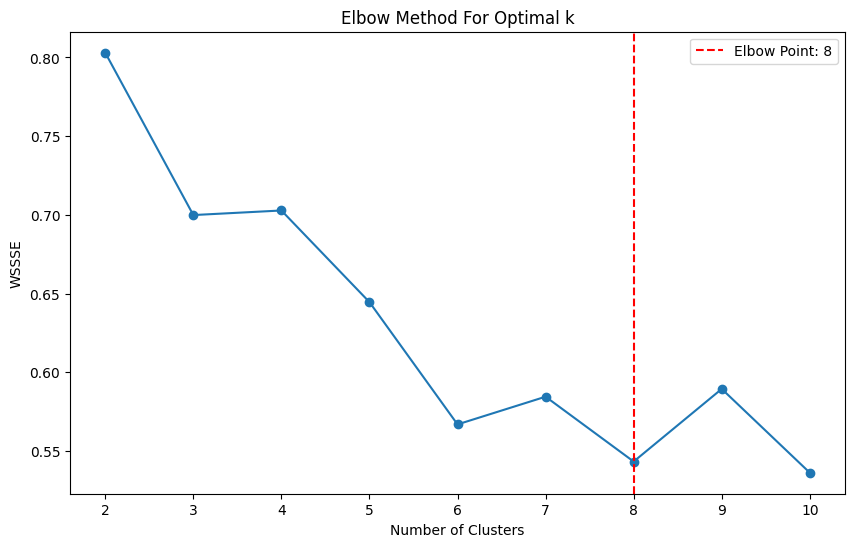

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import MinMaxScaler

# Load the data 
data = spark.read.csv("clustering.csv", header=True, inferSchema=True)

# Select features for clustering
feature_columns = ['average_length', 'average_duration', 'max_duration', 'min_duration']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

wssse_list = []
cluster_range = range(2, 11)  # Try clustering for K from 2 to 10

for k in cluster_range:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(data)
    transformed = model.transform(data)
    
    # Calculate WSSSE
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette')
    wssse = evaluator.evaluate(transformed)
    wssse_list.append(wssse)

# Kneedle algorithm to determine the elbow point
def kneedle_algorithm(wssse_list, cluster_range):
    # Normalize the WSSSE values
    wssse_scaled = MinMaxScaler().fit_transform(np.array(wssse_list).reshape(-1, 1)).flatten()
    
    # Calculate the differences between consecutive WSSSE values
    differences = np.diff(wssse_scaled)
    
    # Calculate the second derivative (the change of differences)
    second_derivative = np.diff(differences)
    
    # Find the elbow point: point of maximum curvature (minimum second derivative)
    elbow_point_index = np.argmin(second_derivative) + 2  # +2 to adjust for index shift and original range start

    return elbow_point_index

# Determine the elbow point
elbow_point = kneedle_algorithm(wssse_list, cluster_range)
print(f'The optimal number of clusters is: {elbow_point}')

# Plot WSSSE vs. Number of Clusters with the elbow point
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wssse_list, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.xlabel('Number of Clusters')
plt.ylabel('WSSSE')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()


In [32]:
# data = spark.read.csv("clustering.csv", header=True, inferSchema=True)

# # Select features for clustering
# feature_columns = [
#     'average_length','average_duration','max_duration','min_duration'
# ]
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# data = assembler.transform(data)

# wssse_list = []
# cluster_range = range(2, 11)  # Try clustering for K from 2 to 10

# for k in cluster_range:
#     kmeans = KMeans().setK(k).setSeed(1)
#     model = kmeans.fit(data)
#     transformed = model.transform(data)
    
#     # Calculate WSSSE
#     evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette')
#     wssse = evaluator.evaluate(transformed)
#     wssse_list.append(wssse)

# # Plot WSSSE vs. Number of Clusters
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, wssse_list, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WSSSE')
# plt.title('Elbow Method For Optimal k')
# plt.show()

# Assemble features into a feature vector
# Assemble features into a feature vector
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# data = assembler.transform(data)

# Apply PCA to reduce the dimensionality to 2
# pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
# pca_model = pca.fit(data)
# pca_result = pca_model.transform(data)

# Trains a k-means model
kmeans = KMeans(featuresCol="features", k=elbow_point, seed=1)  # Adjust K as needed
model = kmeans.fit(data)

# Make predictions
predictions = model.transform(data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# predictions.select("features", "prediction").show(truncate=False)
predictions.groupBy('prediction') \
            .agg(collect_list(col = 'component').alias('processes')) \
            .show(truncate=False)
# predictions.toPandas().to_csv("clusters.csv", header=True)


# Convert to Pandas DataFrame for visualization
# pandas_df = predictions.select("pcaFeatures", "prediction").toPandas()
# pandas_df["pcaFeature1"] = pandas_df["pcaFeatures"].apply(lambda x: x[0])
# pandas_df["pcaFeature2"] = pandas_df["pcaFeatures"].apply(lambda x: x[1])

# # Plot the clusters
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(pandas_df["pcaFeature1"], pandas_df["pcaFeature2"], c=pandas_df["prediction"], cmap="viridis")
# plt.scatter([center[0] for center in centers], [center[1] for center in centers], c='red', marker='x')  # Cluster centers
# plt.title("KMeans Clustering with PCA")
# plt.xlabel("PCA Feature 1")
# plt.ylabel("PCA Feature 2")
# plt.colorbar(scatter, label="Cluster")
# plt.show()

Silhouette with squared euclidean distance = 0.5432189294943496
Cluster Centers: 
[3.11111111e+00 3.05360688e+03 3.95633333e+03 2.55622222e+03]
[5.0000e+00 2.0577e+04 2.0577e+04 2.0577e+04]
[5.0000e+00 9.5460e+03 1.1693e+04 7.6394e+03]
[5.00000e+00 1.66745e+04 1.66745e+04 1.66745e+04]
[1.00000000e+00 8.90261905e+02 1.68100000e+03 4.18125000e+02]
[4.9000e+00 7.3022e+03 7.3022e+03 7.3022e+03]
[5.0000000e+00 1.4313125e+04 1.5849750e+04 1.2776500e+04]
[4.77777778e+00 5.24046296e+03 5.82944444e+03 4.83411111e+03]
+----------+----------------------------------------------------------------------------------------------------+
|prediction|processes                                                                                           |
+----------+----------------------------------------------------------------------------------------------------+
|1         |[77]                                                                                                |
|6         |[455266533376, 85,

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `pcaFeatures` cannot be resolved. Did you mean one of the following? [`features`, `component`, `prediction`, `_c0`, `max_duration`].;
'Project ['pcaFeatures, prediction#21060]
+- Project [_c0#19127, component#19128L, average_length#19129, average_duration#19130, max_duration#19131, min_duration#19132, features#19142, UDF(features#19142) AS prediction#21060]
   +- Project [_c0#19127, component#19128L, average_length#19129, average_duration#19130, max_duration#19131, min_duration#19132, UDF(struct(average_length, average_length#19129, average_duration, average_duration#19130, max_duration_double_VectorAssembler_f5b3fac97ab0, cast(max_duration#19131 as double), min_duration_double_VectorAssembler_f5b3fac97ab0, cast(min_duration#19132 as double))) AS features#19142]
      +- Relation [_c0#19127,component#19128L,average_length#19129,average_duration#19130,max_duration#19131,min_duration#19132] csv
